# Stock Pattern Recognition DL

In [31]:
### import library
import numpy as np
import pandas as pd
from cassandra.cluster import Cluster
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

### 1️⃣ ดึงข้อมูลจาก Cassandra

In [32]:
# --------------------------
# 1) Get data from Cassandra
# --------------------------
def get_candlestick_data(symbol: str, limit: int = 3000,
                         contact_points=['127.0.0.1'], port=9042,
                         keyspace='data_stock'):
    cluster = Cluster(contact_points, port=port)
    session = cluster.connect(keyspace)
    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol = '{symbol}'
        ORDER BY time DESC
        LIMIT {limit}
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("No rows returned from Cassandra - check query/keyspace/table/symbol.")
    df.columns = df.columns.str.strip().str.lower()
    df.rename(columns={
        'open_price': 'open',
        'high_price': 'high',
        'low_price': 'low',
        'close_price': 'close'
    }, inplace=True)
    df = df.sort_values('time')  # oldest -> newest
    df.set_index('time', inplace=True)
    return df

# Example usage:
# df = get_candlestick_data('AOT.BK', limit=3000)
# print(df.head()); print("len:", len(df))



### 2️⃣ Preprocessing & Feature Engineering

In [ ]:
# -------------------------------------
# 2) detect_head_shoulders (simple rule)
# -------------------------------------
def detect_head_shoulders(df, distance=5, tolerance=0.05, debug=False):
    prices = df['close'].values
    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    patterns = []

    # H&S
    for i in range(2, len(peaks)):
        l, h, r = peaks[i-2], peaks[i-1], peaks[i]
        left, head, right = prices[l], prices[h], prices[r]
        if head > left and head > right and abs(left - right) / max(head,1e-9) < tolerance:
            neck_left = np.min(prices[l:h]) if h - l > 0 else prices[l]
            neck_right = np.min(prices[h:r]) if r - h > 0 else prices[r]
            neck_slope = (neck_right - neck_left) / max((r - l), 1)
            post_pattern = prices[r:]
            neckline_series = neck_right + neck_slope * np.arange(1, len(post_pattern) + 1)
            below = np.where(post_pattern < neckline_series)[0]
            if below.size > 0:
                break_idx = r + int(below[0])
                patterns.append({
                    'type': 'H&S',
                    'left_idx': int(l),
                    'head_idx': int(h),
                    'right_idx': int(r),
                    'neck_slope': float(neck_slope),
                    'break_idx': int(break_idx)
                })
                if debug:
                    print("H&S:", l, h, r, "break:", break_idx)

    # IH&S
    for i in range(2, len(troughs)):
        l, h, r = troughs[i-2], troughs[i-1], troughs[i]
        left, head, right = prices[l], prices[h], prices[r]
        if head < left and head < right and abs(left - right) / max(abs(head),1e-9) < tolerance:
            neck_left = np.max(prices[l:h]) if h - l > 0 else prices[l]
            neck_right = np.max(prices[h:r]) if r - h > 0 else prices[r]
            neck_slope = (neck_right - neck_left) / max((r - l), 1)
            post_pattern = prices[r:]
            neckline_series = neck_right + neck_slope * np.arange(1, len(post_pattern) + 1)
            above = np.where(post_pattern > neckline_series)[0]
            if above.size > 0:
                break_idx = r + int(above[0])
                patterns.append({
                    'type': 'IH&S',
                    'left_idx': int(l),
                    'head_idx': int(h),
                    'right_idx': int(r),
                    'neck_slope': float(neck_slope),
                    'break_idx': int(break_idx)
                })
                if debug:
                    print("IH&S:", l, h, r, "break:", break_idx)

    return patterns




### 3️⃣ สร้าง Label (H&S / IH&S / None)

In [ ]:
# -------------------------------------------------
# 3) Create labels array (0 = none, 1 = H&S, 2 = IH&S)
# -------------------------------------------------
# block_3_create_labels.py
import numpy as np

def create_labels_from_patterns(length, patterns):
    labels = np.zeros(length, dtype=np.int32)
    for p in patterns:
        idx = int(p['head_idx'])
        if 0 <= idx < length:
            if p['type'] == 'H&S':
                labels[idx] = 1
            elif p['type'] == 'IH&S':
                labels[idx] = 2
    return labels



### 4️⃣ สร้าง labels สำหรับ Deep Learning

In [ ]:
# ----------------------------------------------------
# 4) Preprocess features and create sequences for LSTM
# ----------------------------------------------------
def preprocess_and_create_sequences(df, labels, seq_len=30, features_cols=None):
    if features_cols is None:
        features_cols = ['open', 'high', 'low', 'close', 'volume']

    data = df[features_cols].fillna(method='ffill').fillna(method='bfill').values.astype(np.float32)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    Xs, ys = [], []
    for i in range(len(data_scaled) - seq_len):
        Xs.append(data_scaled[i:i+seq_len])
        ys.append(labels[i+seq_len-1])
    X = np.array(Xs)
    y = np.array(ys, dtype=np.int32)
    return X, y, scaler



### 5️⃣ สร้าง LSTM Model ด้วย Keras

In [36]:
# -----------------------------------------
# 5) Build a simple LSTM model (Keras)
# -----------------------------------------
def build_lstm_model(seq_len, n_features, n_classes=3):
    model = Sequential([
        LSTM(64, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Example usage:
# model = build_lstm_model(seq_len=30, n_features=X.shape[2], n_classes=3)
# model.summary()


### 6️⃣ Train / Validate

In [37]:
# ----------------------------------------------------
# 6) Train pipeline including class weighting / balance
# ----------------------------------------------------
# block_6_train_pipeline.py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# imports for oversample
from sklearn.utils import resample
import pandas as pd

# assume functions imported from previous blocks:
# get_candlestick_data, detect_head_shoulders, create_labels_from_patterns,
# preprocess_and_create_sequences, build_lstm_model

def train_pipeline(symbol='AOT.BK', cass_limit=3000, seq_len=30,
                   test_size=0.2, detect_distance=5, detect_tolerance=0.05,
                   use_class_weight=True, oversample=False, epochs=50, batch_size=32):
    # fetch
    df = get_candlestick_data(symbol, limit=cass_limit)
    print("Data length:", len(df))

    # detect
    patterns = detect_head_shoulders(df, distance=detect_distance, tolerance=detect_tolerance, debug=False)
    labels = create_labels_from_patterns(len(df), patterns)
    unique, counts = np.unique(labels, return_counts=True)
    print("Label distribution (0/1/2):", dict(zip(unique, counts)))

    # preprocess
    X, y, scaler = preprocess_and_create_sequences(df, labels, seq_len=seq_len)
    print("X,y shapes:", X.shape, y.shape)
    if X.shape[0] == 0:
        raise ValueError("Not enough data to build sequences. Increase cass_limit or reduce seq_len.")

    # split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)
    print("Train/Val shapes:", X_train.shape, X_val.shape)

    # class weight
    cw = None
    if use_class_weight:
        classes = np.unique(y_train)
        weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        cw = {int(c): float(w) for c,w in zip(classes, weights)}
        print("Class weights:", cw)

    # optional oversample
    if oversample:
        train_data = list(zip(X_train, y_train))
        df_train = pd.DataFrame(train_data, columns=['X','y'])
        majority = df_train[df_train['y']==0]
        target_n = max(1, int(len(majority)//2))
        frames = [majority]
        for cls in [1,2]:
            subset = df_train[df_train['y']==cls]
            if len(subset) == 0:
                continue
            up = resample(subset, replace=True, n_samples=target_n, random_state=42)
            frames.append(up)
        df_bal = pd.concat(frames).sample(frac=1, random_state=42)
        X_train = np.stack(df_bal['X'].values)
        y_train = np.array(df_bal['y'].values)
        print("After oversample Train shapes:", X_train.shape, y_train.shape)

    # one-hot
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_val_cat = to_categorical(y_val, num_classes=3)

    # build model
    model = build_lstm_model(seq_len, X.shape[2], n_classes=3)
    model.summary()

    # fit with early stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
    history = model.fit(X_train, y_train_cat,
                        validation_data=(X_val, y_val_cat),
                        epochs=epochs, batch_size=batch_size,
                        class_weight=cw,
                        callbacks=callbacks,
                        verbose=2)
    return model, history, (X_train, X_val, y_train, y_val, y_train_cat, y_val_cat), scaler, patterns

# Example usage:
# model, history, datasets, scaler, patterns = train_pipeline(symbol='AOT.BK', cass_limit=3000, seq_len=30, epochs=30)


### 7️⃣ ใช้โมเดลทำนาย

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix:
[[  0   0 259]
 [  0   0   7]
 [  0   0   8]]

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       259
           1     0.0000    0.0000    0.0000         7
           2     0.0292    1.0000    0.0567         8

    accuracy                         0.0292       274
   macro avg     0.0097    0.3333    0.0189       274
weighted avg     0.0009    0.0292    0.0017       274



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

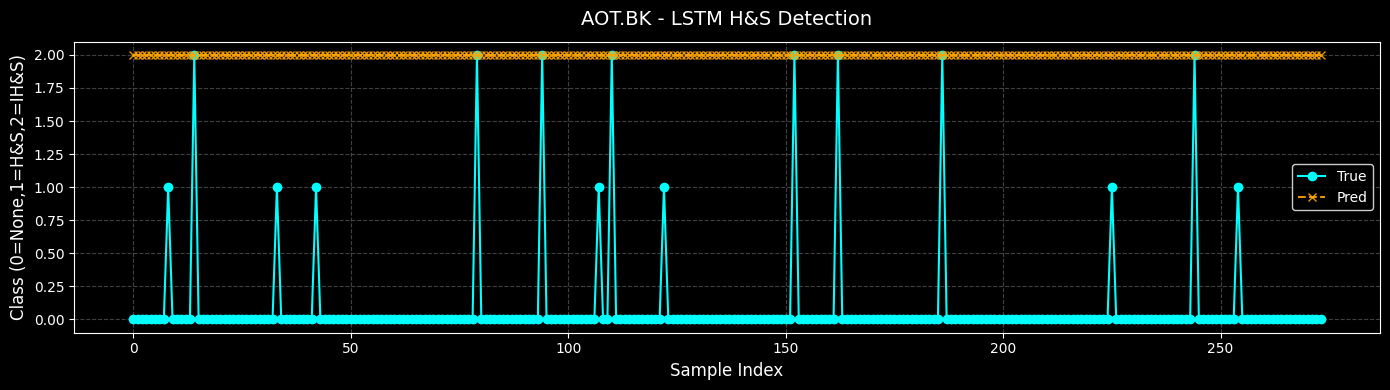

In [41]:
# ----------------------------------------------------
# 7) Evaluate and visualize results
# ----------------------------------------------------
def evaluate_and_plot(model, X_val, y_val, y_val_cat=None, symbol='SYMBOL'):
    y_pred = model.predict(X_val)
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = y_val  # integer labels

    print("Confusion Matrix:")
    print(confusion_matrix(y_true_cls, y_pred_cls))
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls, digits=4))

    # --- เริ่มส่วนกราฟสีเข้ม ---
    plt.style.use('dark_background')
    plt.figure(figsize=(14, 4), facecolor='black')

    plt.plot(y_true_cls, label='True', marker='o', linestyle='-', color='cyan', linewidth=1.5)
    plt.plot(y_pred_cls, label='Pred', marker='x', linestyle='--', color='orange', alpha=0.9, linewidth=1.5)

    plt.title(f"{symbol} - LSTM H&S Detection", color='white', fontsize=14, pad=12)
    plt.xlabel("Sample Index", color='white', fontsize=12)
    plt.ylabel("Class (0=None,1=H&S,2=IH&S)", color='white', fontsize=12)
    plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
    plt.grid(True, color='gray', linestyle='--', alpha=0.5)

    # ปรับสีตัวเลขแกน
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')

    plt.tight_layout()
    plt.show()


# Example usage:
evaluate_and_plot(model, X_val, y_val, symbol='AOT.BK')
